In [1]:
#!pip install yfinance

In [2]:
import yfinance as yf

msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [3]:
import os
import pandas as pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        msft_hist = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    msft_hist.to_json(DATA_PATH)

In [4]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,0.055380,0.063524,0.055380,0.060809,1031788800,0.0,0.0
1986-03-14 05:00:00,0.060809,0.064067,0.060809,0.062980,308160000,0.0,0.0
1986-03-17 05:00:00,0.062980,0.064609,0.062980,0.064067,133171200,0.0,0.0
1986-03-18 05:00:00,0.064067,0.064609,0.061894,0.062437,67766400,0.0,0.0
1986-03-19 05:00:00,0.062437,0.062980,0.060809,0.061351,47894400,0.0,0.0


<AxesSubplot:>

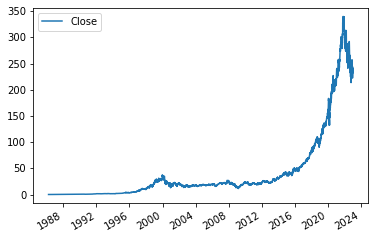

In [5]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [6]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [7]:
data.head()

,Actual_Close,Target
1986-03-13 05:00:00,0.060809,NaN
1986-03-14 05:00:00,0.062980,1.0
1986-03-17 05:00:00,0.064067,1.0
1986-03-18 05:00:00,0.062437,0.0
1986-03-19 05:00:00,0.061351,0.0


In [8]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [9]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
1986-03-13 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 05:00:00,0.055380,0.063524,0.055380,0.060809,1.031789e+09,0.0,0.0
1986-03-17 05:00:00,0.060809,0.064067,0.060809,0.062980,3.081600e+08,0.0,0.0
1986-03-18 05:00:00,0.062980,0.064609,0.062980,0.064067,1.331712e+08,0.0,0.0
1986-03-19 05:00:00,0.064067,0.064609,0.061894,0.062437,6.776640e+07,0.0,0.0


In [10]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [11]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
1986-03-14 05:00:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 05:00:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 05:00:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064609,0.062980
1986-03-19 05:00:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894
1986-03-20 05:00:00,0.059723,0.0,0.061351,4.789440e+07,0.062437,0.062980,0.060809


In [12]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [13]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [14]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.47368421052631576